<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/06-GenerativeAdversarialNetworks/RedCarGAN_Train_CustomNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [ ]:
! nvidia-smi

Fri Sep 11 09:16:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! sudo apt install imagemagick

In [ ]:
! git clone https://github.com/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2

Cloning into 'TSAI-DeepVision-EVA4.0-Phase-2'...
remote: Enumerating objects: 3063, done.
remote: Counting objects: 100% (3063/3063), done.
remote: Compressing objects: 100% (3037/3037), done.
remote: Total 3527 (delta 50), reused 3015 (delta 24), pack-reused 464
Receiving objects: 100% (3527/3527), 96.60 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (196/196), done.


In [ ]:
import os
import random
import torch
import time

import torch.nn as nn
import torch.nn.utils as tutils
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
from matplotlib import rc
import seaborn as sns
from IPython import display

from pathlib import Path
from torchsummary import summary

sns.set()

## Training Setup

In [ ]:
# Root directory for dataset
dataroot = "/content/TSAI-DeepVision-EVA4.0-Phase-2/06-GenerativeAdversarialNetworks/car_images_100x100"

# Batch size during training
batch_size = 256

image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 64

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1960

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=T.Compose([
                                                T.Resize((image_size, image_size)),
                                                T.ToTensor(),
                                                T.Normalize(mean=[0.570838093757629, 0.479552984237671, 0.491760671138763], std=[0.279659748077393, 0.309973508119583, 0.311098515987396]),
                                                ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

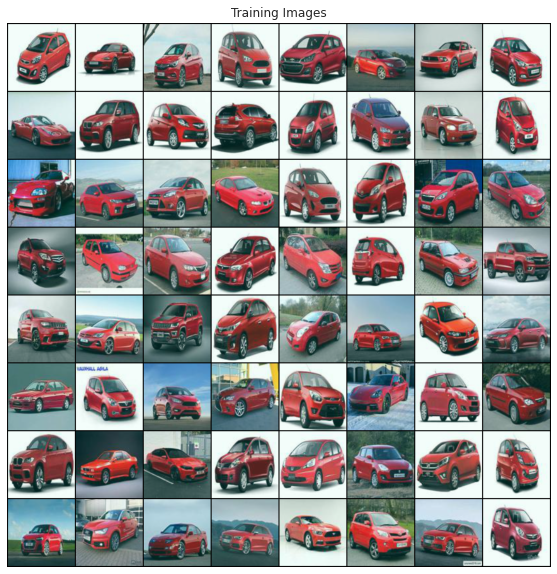

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Models

## Generator Code

In [ ]:
class Generator(nn.Module):
    """
    Creates the Generator

    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nz: int = 64, ngf: int = 64):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

## Discriminator Code

In [ ]:
class Discriminator(nn.Module):
    """
    Creates the Discriminator

    nc (int): number of channels of the input image
    ndf (int): number of feature maps for the discriminator

    This uses the special Spectral Normalization ref: https://arxiv.org/abs/1802.05957
    """
    def __init__(self, nc: int = 3, ndf: int = 64):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            torch.nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## Instantiate our models

In [ ]:
# Create the Discriminator
netD = Discriminator(nc, ndf).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (11): Sigmoid()
  )
)

In [ ]:
# Create the generator
netG = Generator(nz, ngf).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(6

## Check the sizes

In [ ]:
summary(netD, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
         LeakyReLU-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         262,144
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 4, 4]       1,048,576
        LeakyReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11              [-1, 1, 1, 1]           4,096
          Sigmoid-12              [-1, 1, 1, 1]               0
Total params: 1,973,248
Trainable params: 1,973,248
Non-trainable params: 0
---------------------------

In [ ]:
summary(netG, input_size=(64, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         524,288
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]          65,536
      BatchNorm2d-14           [-1, 64,

In [ ]:
netD(torch.randn(128, 3, 128, 128).to(device)).shape

torch.Size([128, 1, 1, 1])

In [ ]:
netG(torch.randn(128, 64, 1, 1).to(device)).shape

torch.Size([128, 3, 128, 128])

# Training

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

print(f"=> Starting Training Loop for {num_epochs} epochs\n")

print_freq = 20

curr_time = time.time()
# For each epoch
for epoch in range(num_epochs):

    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    epoch_end = time.time()

    # Output training stats every `print_freq` or if its end epoch
    if epoch % print_freq == 0 or epoch == num_epochs -1:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        generator_log = Path('generator_log')
        generator_log.mkdir(parents=True, exist_ok=True) 

        plt.imsave(generator_log / f'g_log_{epoch:04}.jpg', np.transpose(img_list[-1].numpy(), (1, 2, 0)))

        checkpoint_dir = Path('checkpoints')
        checkpoint_dir.mkdir(parents=True, exist_ok=True)

        torch.save(netG.state_dict(), checkpoint_dir / f'netG_chkpt_{epoch:04}.pth')

        print('=> Epoch [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tTime: %.5fs'
                  % (epoch, num_epochs-1, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, time.time()-curr_time))
        # start the timer again
        curr_time = time.time()

=> Starting Training Loop for 1960 epochs

=> Epoch [0/1959]	Loss_D: 0.7233	Loss_G: 0.8271	D(x): 0.9552	D(G(z)): 0.4908 / 0.4373	Time: 2.73299s
=> Epoch [20/1959]	Loss_D: 0.7352	Loss_G: 0.8498	D(x): 0.9563	D(G(z)): 0.4854 / 0.4283	Time: 51.12913s
=> Epoch [40/1959]	Loss_D: 0.8998	Loss_G: 0.6290	D(x): 0.8931	D(G(z)): 0.5418 / 0.5338	Time: 51.17647s
=> Epoch [60/1959]	Loss_D: 2.4906	Loss_G: 0.3894	D(x): 0.9999	D(G(z)): 0.9138 / 0.6780	Time: 51.16953s
=> Epoch [80/1959]	Loss_D: 1.0975	Loss_G: 0.5461	D(x): 0.8492	D(G(z)): 0.6045 / 0.5801	Time: 51.19199s
=> Epoch [100/1959]	Loss_D: 0.9944	Loss_G: 0.6917	D(x): 0.8364	D(G(z)): 0.5526 / 0.5020	Time: 51.24778s
=> Epoch [120/1959]	Loss_D: 0.9705	Loss_G: 0.6918	D(x): 0.8573	D(G(z)): 0.5494 / 0.5023	Time: 51.22026s
=> Epoch [140/1959]	Loss_D: 0.9389	Loss_G: 0.7437	D(x): 0.9526	D(G(z)): 0.5869 / 0.4767	Time: 51.18545s
=> Epoch [160/1959]	Loss_D: 0.7966	Loss_G: 0.8664	D(x): 0.9233	D(G(z)): 0.5061 / 0.4244	Time: 51.12714s
=> Epoch [180/1959]	Loss_D: 

In [ ]:
! ls -hl checkpoints

total 1.3G
-rw-r--r-- 1 root root 13M Sep 11 11:28 netG_chkpt_0000.pth
-rw-r--r-- 1 root root 13M Sep 11 11:29 netG_chkpt_0020.pth
-rw-r--r-- 1 root root 13M Sep 11 11:30 netG_chkpt_0040.pth
-rw-r--r-- 1 root root 13M Sep 11 11:30 netG_chkpt_0060.pth
-rw-r--r-- 1 root root 13M Sep 11 11:31 netG_chkpt_0080.pth
-rw-r--r-- 1 root root 13M Sep 11 11:32 netG_chkpt_0100.pth
-rw-r--r-- 1 root root 13M Sep 11 11:33 netG_chkpt_0120.pth
-rw-r--r-- 1 root root 13M Sep 11 11:34 netG_chkpt_0140.pth
-rw-r--r-- 1 root root 13M Sep 11 11:35 netG_chkpt_0160.pth
-rw-r--r-- 1 root root 13M Sep 11 11:36 netG_chkpt_0180.pth
-rw-r--r-- 1 root root 13M Sep 11 11:36 netG_chkpt_0200.pth
-rw-r--r-- 1 root root 13M Sep 11 11:37 netG_chkpt_0220.pth
-rw-r--r-- 1 root root 13M Sep 11 11:38 netG_chkpt_0240.pth
-rw-r--r-- 1 root root 13M Sep 11 11:39 netG_chkpt_0260.pth
-rw-r--r-- 1 root root 13M Sep 11 11:40 netG_chkpt_0280.pth
-rw-r--r-- 1 root root 13M Sep 11 11:41 netG_chkpt_0300.pth
-rw-r--r-- 1 root root 13M Se

In [ ]:
! zip -rq car_gan_g_log.zip generator_log/
! zip -rq car_gan_custom_checkpoints.zip checkpoints/

Save the model and the optimizer states

In [ ]:
state = {
    'epoch': epoch,
    'netD': netD.state_dict(),
    'netG': netG.state_dict(),
    'optimizerD': optimizerD.state_dict(),
    'optimizerG': optimizerG.state_dict(),
    'img_list': img_list
}
torch.save(state, '/gdrive/My Drive/EVA4P2/06-GenerativeAdversarialNetworks/carGAN_custom_checkpoint.pth')

## Train Logs

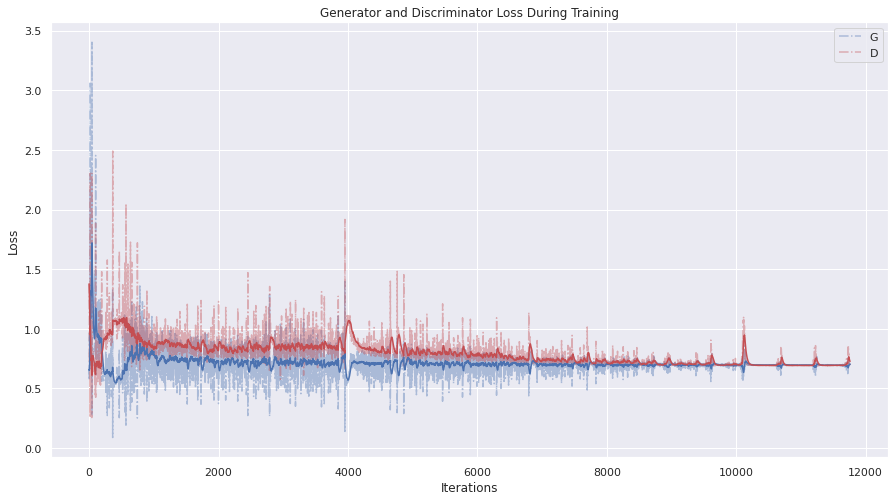

In [ ]:
def smooth_curv(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return np.array(smoothed)

plt.figure(figsize=(15, 8))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, 'b-.',label="G", alpha=0.4)
plt.plot(D_losses, 'r-.', label="D", alpha=0.4)
plt.plot(smooth_curv(G_losses, 0.95), 'b')
plt.plot(smooth_curv(D_losses, 0.95), 'r')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [ ]:
%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

In [ ]:
rc('animation', html='html5')

In [ ]:
anim

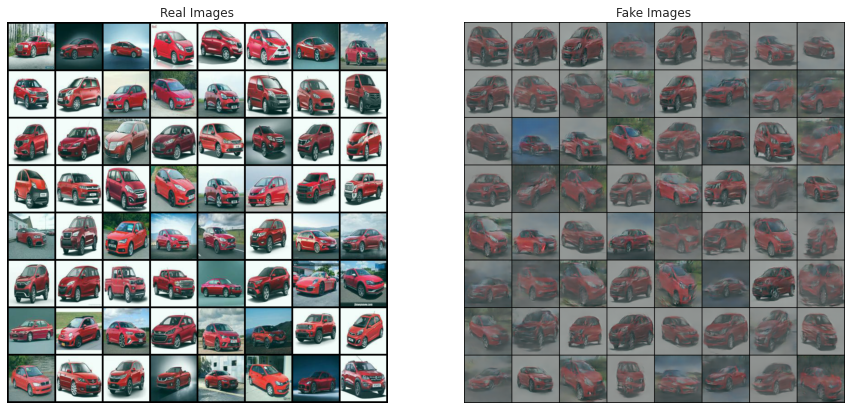

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-10],(1, 2, 0)))
plt.show()

In [ ]:
def norm_ip(img, min, max):
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max - min + 1e-5)

def norm_tensor(t):
    norm_ip(t, float(t.min()), float(t.max()))

In [ ]:
netG.load_state_dict(torch.load('checkpoints/netG_chkpt_1520.pth'))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    fake = netG(torch.randn(1, 64, 1, 1).to(device)).detach().cpu()
fakei = fake[0]
norm_tensor(fakei)

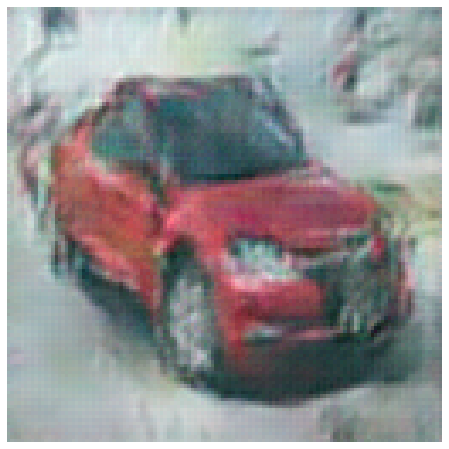

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(fakei.permute(1, 2, 0))
plt.axis('off')
plt.grid('off')

## Save the Generator

In [ ]:
torch.save(netG, '/gdrive/My Drive/EVA4P2/06-GenerativeAdversarialNetworks/red_car_gan_generator.pt')

In [ ]:
traced_model = torch.jit.trace(netG.to('cpu'), torch.randn(1, 64, 1, 1))

In [ ]:
traced_model.save('/gdrive/My Drive/EVA4P2/06-GenerativeAdversarialNetworks/red_car_gan_generator.traced.pt')

## Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
! cp /content/car_gan_custom_checkpoints.zip /gdrive/My\ Drive/EVA4P2/06-GenerativeAdversarialNetworks/
! cp /content/car_gan_g_log.zip /gdrive/My\ Drive/EVA4P2/06-GenerativeAdversarialNetworks/

### DANGER

In [ ]:
drive.flush_and_unmount()

In [ ]:
! rm -r /content/generator_log

In [ ]:
! rm -r /content/checkpoints/